### **SPLEX PROJECT: Legendary predictions based on Pokémon stats**
*LEGOFFIC LIAM and ZHONG YANN*

This project is a data science exploration project in which we seek to use fundamental methods in data science analysis, most notably clustering and dimensionality reduction, in order to analyse and predict whethere "Pokémon", inhabitants of one of the world's greatest grossing franchises, are legendary or not. Moreover, we would also like to answer other questions that pertain to the correlation of a Pokémon's stats with itself - are its stats predictable enough to guess, based on one or two stats?

Currently, the fundamental questions we seek to answer are:
- Can we infer a Pokémon's legendary status from its base stat total? (likely, yes)
- Can we infer a Pokémon's legendary status from its individual stats (hard to say)
- Do Pokémon's attack stats correlate with their defense stats?
- Do Pokémon's special attack stats correlate with their special defense stats?

In [1]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from math import pi
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from src.weight_method import *

# To change matplotlib figure size
matplotlib.rcParams['figure.dpi'] = 100    

In [10]:
# Read in input file
data = pd.read_csv('data/Pokemon.csv')
# Read in alternative, more complete input file ==> includes an extra generation
data = pd.read_csv('data/pokemon_dataset_2.csv') 

data

,Attack,base_egg_steps,base_happiness,Total,capture_rate,classfication,Defense,experience_growth,height_m,HP,...,percentage_male,#,Sp. Atk,Sp. Def,Speed,Type 1,Type 2,weight_kg,Generation,Legendary
0,49,5120,70,318,45,Seed Pokémon,49,1059860,0.7,45,...,88.1,1,65,65,45,grass,poison,6.9,1,False
1,62,5120,70,405,45,Seed Pokémon,63,1059860,1.0,60,...,88.1,2,80,80,60,grass,poison,13.0,1,False
2,100,5120,70,625,45,Seed Pokémon,123,1059860,2.0,80,...,88.1,3,122,120,80,grass,poison,100.0,1,False
3,52,5120,70,309,45,Lizard Pokémon,43,1059860,0.6,39,...,88.1,4,60,50,65,fire,NaN,8.5,1,False
4,64,5120,70,405,45,Flame Pokémon,58,1059860,1.1,58,...,88.1,5,80,65,80,fire,NaN,19.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,101,30720,0,570,25,Launch Pokémon,103,1250000,9.2,97,...,NaN,797,107,101,61,steel,flying,999.9,7,True
797,181,30720,0,570,255,Drawn Sword Pokémon,131,1250000,0.3,59,...,NaN,798,59,31,109,grass,steel,0.1,7,True
798,101,30720,0,570,15,Junkivore Pokémon,53,1250000,5.5,223,...,NaN,799,97,53,43,dark,dragon,888.0,7,True
799,107,30720,0,600,3,Prism Pokémon,101,1250000,2.4,97,...,NaN,800,127,89,79,psychic,NaN,230.0,7,True


### PART A: Visualising the dataset

Before anything, we would like to visualise the rough spread of the Pokémon's base stat totals, as well as individual stats, over a density plot. 
This should enable us to have a global idea of what the general spread of stats, as well as outliers, is.
We would also like to look at the rough number of Pokémon per types in a histogram.

In [11]:
# Split legendaries and non-legendaries into two datasets
legendaries = data[data['Legendary']==True]
plebians = data[data['Legendary']==False]
raw_stats_no_total = data[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]]
raw_stats = data[["Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed", "Legendary"]]

The average base stat total for legendaries and non legendaries is respectively 615.2571428571429 and 410.4815321477428
Below, a density distribution of base stat totals of all Pokémon over all generations:


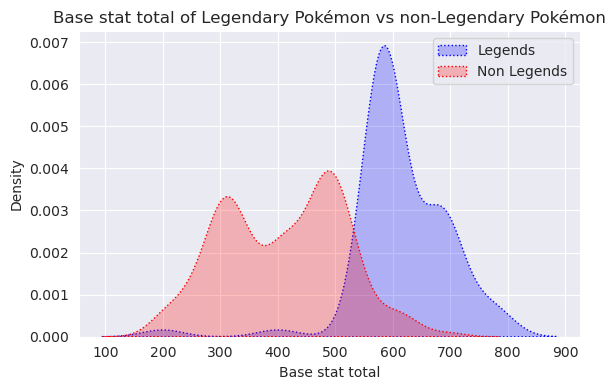

In [12]:
# Calculate average base stats
avg_l_base = sum(legendaries["Total"])/len(legendaries)
avg_p_base = sum(plebians["Total"])/len(plebians)

# Calculate average stats per generation for putting into a radar plot

print("The average base stat total for legendaries and non legendaries is respectively "+ str(avg_l_base) + " and " + str(avg_p_base))

# Append base stats into list
l_base_list = []
p_base_list = []

for base in legendaries["Total"]:
    l_base_list.append(base)
for base in plebians["Total"]:
    p_base_list.append(base)

print("Below, a density distribution of base stat totals of all Pokémon over all generations:")

# Density plot
fig, ax = plt.subplots()
sns.kdeplot(l_base_list,shade=True,color="blue",label="Legends",linestyle ="dotted")
sns.kdeplot(p_base_list,shade=True,color="red",label="Non Legends",linestyle ="dotted")
plt.title("Base stat total of Legendary Pokémon vs non-Legendary Pokémon")
plt.xlabel("Base stat total")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Below, the boxen plot distribution of base stats per generation:


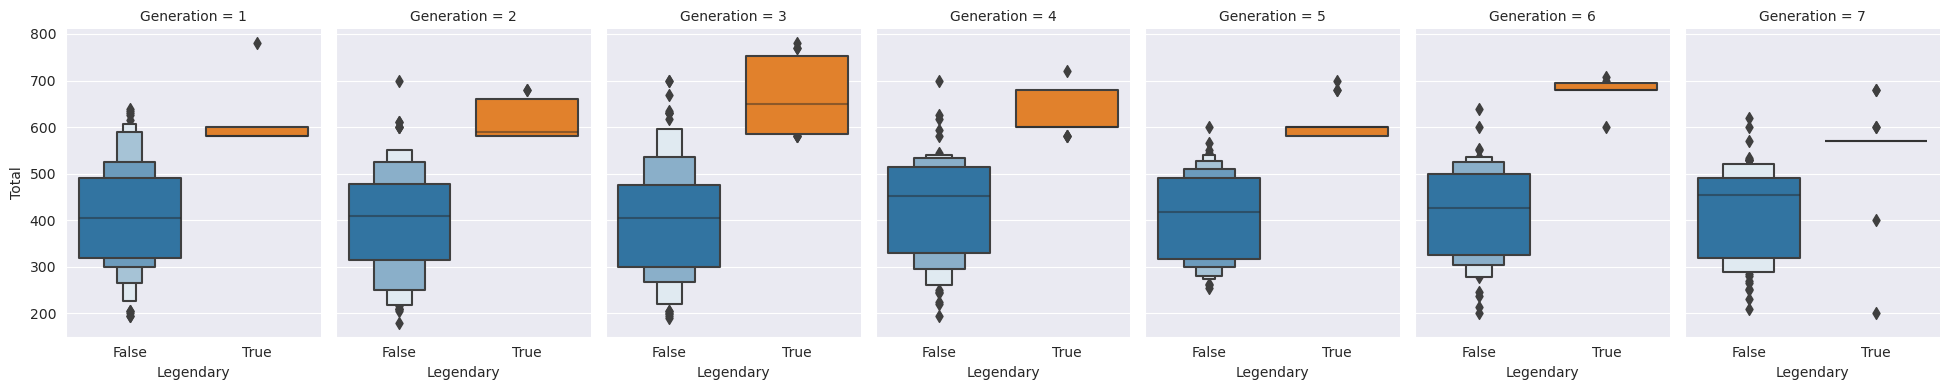

In [13]:
# Visualise boxplots of base stat totals per generation
print("Below, the boxen plot distribution of base stats per generation:")
base_total_plot = sns.catplot(x = "Legendary", y = "Total", col = "Generation", data = data, kind = "boxen", height=4, aspect=.7)

Below, the point plot distribution of base stats per generation with type 1 grouped by color:


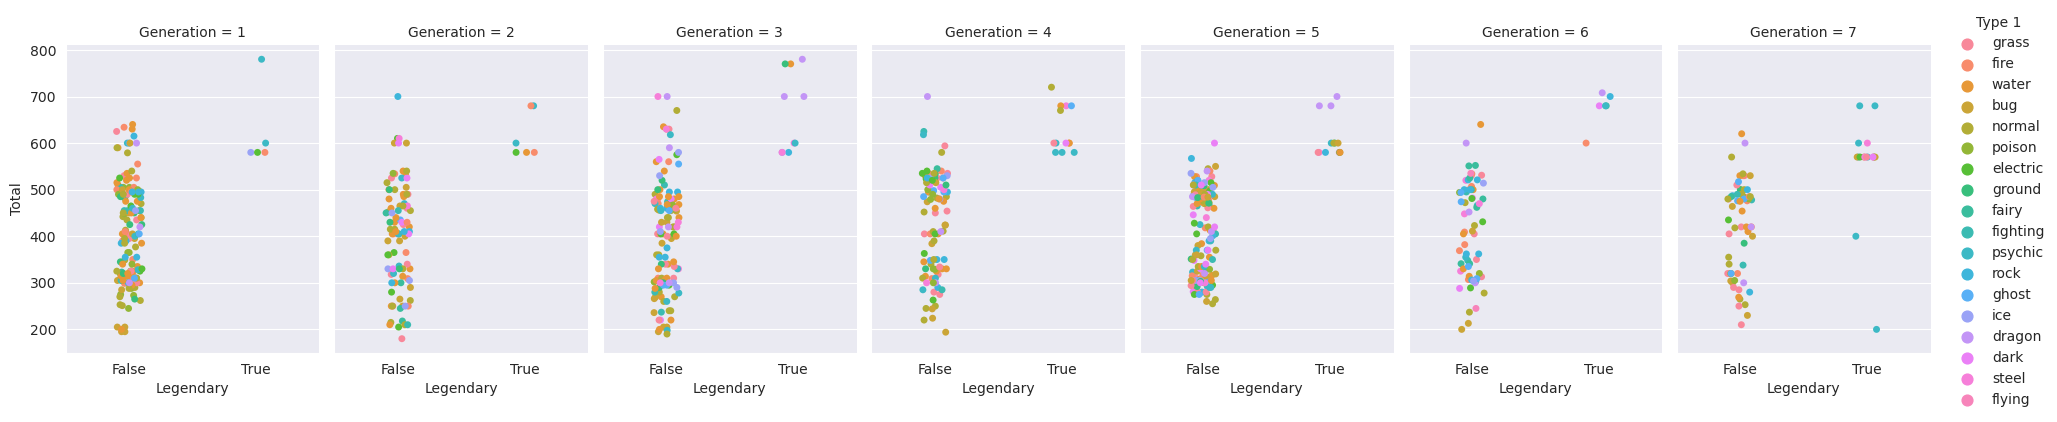

In [14]:
# Similar plot, with confounded type 1 visualisation on a point plot
print("Below, the point plot distribution of base stats per generation with type 1 grouped by color:")
base_total_plot_2 = sns.catplot(x = "Legendary", y = "Total", col = "Generation", hue = "Type 1", data = data, height=4, aspect=.7)

Below, the box plot distribution of stats with outliers, for all Pokémon regardless of generation:


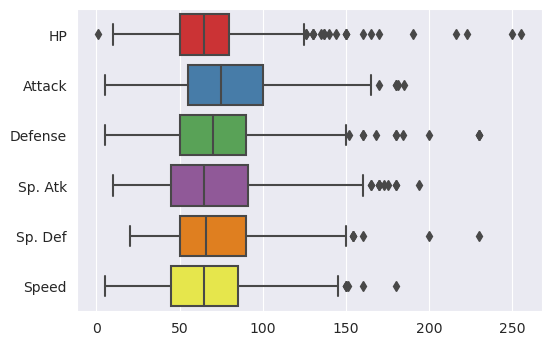

In [15]:
print("Below, the box plot distribution of stats with outliers, for all Pokémon regardless of generation:")
stats_plot = sns.boxplot(data=raw_stats_no_total, orient="h", palette="Set1", showfliers=True)
#stats_plot_no_out = sns.boxplot(data=raw_stats_no_total, orient="h", palette="Set1", showfliers=False) # Remove outliers

In [96]:
# What are the average stats over every generation?
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
stats_list = round(data[stats].mean(),2)
print("Average stats over every generation:")
print("HP: " + str(stats_list[0]) + "; Atk: "+ str(stats_list[1]) + "; Def: "+ str(stats_list[2])+ "; SpAtk: "+ str(stats_list[3])+ "; SpDef: "+ str(stats_list[4])+ "; Speed: "+ str(stats_list[5]) + '\n')

# Split data by generation and get mean of stats
g1 = data[data["Generation"] == 1]
g2 = data[data["Generation"] == 2]
g3 = data[data["Generation"] == 3]
g4 = data[data["Generation"] == 4]
g5 = data[data["Generation"] == 5]
g6 = data[data["Generation"] == 6]
g7 = data[data["Generation"] == 7]

# Get average stats and append into a complete list
stats_list_complete = []
stats_list_complete.append(list(round(g1[stats].mean(),2)))
stats_list_complete.append(list(round(g2[stats].mean(),2)))
stats_list_complete.append(list(round(g3[stats].mean(),2)))
stats_list_complete.append(list(round(g4[stats].mean(),2)))
stats_list_complete.append(list(round(g5[stats].mean(),2)))
stats_list_complete.append(list(round(g6[stats].mean(),2)))
stats_list_complete.append(list(round(g7[stats].mean(),2)))

print("Average stats per generation:")
for line in stats_list_complete:
    print("HP: " + str(line[0]) + "; Atk: "+ str(line[1]) + "; Def: "+ str(line[2])+ "; SpAtk: "+ str(line[3])+ "; SpDef: "+ str(line[4])+ "; Speed: "+ str(line[5]))

Average stats over every generation:
HP: 68.96; Atk: 77.86; Def: 73.01; SpAtk: 71.31; SpDef: 70.91; Speed: 66.33

Average stats per generation:
HP: 64.34; Atk: 74.53; Def: 70.08; SpAtk: 69.4; SpDef: 67.74; Speed: 70.15
HP: 70.98; Atk: 69.96; Def: 71.79; SpAtk: 65.4; SpDef: 73.44; Speed: 61.61
HP: 65.67; Atk: 77.19; Def: 72.64; SpAtk: 71.56; SpDef: 69.39; Speed: 63.58
HP: 73.1; Atk: 82.67; Def: 76.17; SpAtk: 74.64; SpDef: 74.52; Speed: 70.07
HP: 70.31; Atk: 80.56; Def: 71.96; SpAtk: 69.97; SpDef: 67.71; Speed: 66.52
HP: 71.11; Atk: 76.53; Def: 73.56; SpAtk: 76.57; SpDef: 73.19; Speed: 66.65
HP: 70.58; Atk: 84.64; Def: 78.01; SpAtk: 75.25; SpDef: 75.65; Speed: 64.04


In [16]:
def draw_spider_plot_stats(list_stats,color,generation):
# Create angles
    stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
    if list_stats[0] != list_stats[-1]: # Close the circle
        list_stats += list_stats[:1]
    angles = [n / 6 * 2 * pi for n in range(6)] # 6 stats
    angles += angles[:1] # Add in first one again to close the circle ("7th")

# Initialise the spider plot
    ax = plt.subplot(111, polar=True)
# Draw axes
    plt.xticks(angles[:-1], stats, color=color, size=8)
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60,80],["20","40","60","80"], color=color, size=7)
    plt.ylim(0,100)
# Plot data and fill area
    ax.plot(angles, list_stats, color,linewidth=1, linestyle='solid')
    ax.fill(angles, list_stats, color, alpha=0.1)
    plt.title("Generation " + str(generation) + " stat distribution", color=color)
    plt.show()

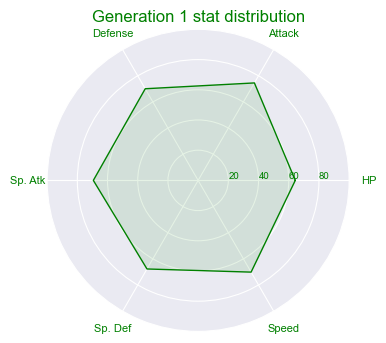

In [99]:
color = "green"
generation = 1
draw_spider_plot_stats(stats_list_complete[0],color,generation)

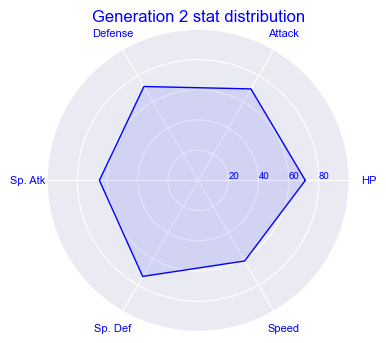

In [100]:
color = "blue"
generation = 2
draw_spider_plot_stats(stats_list_complete[1],color,generation)

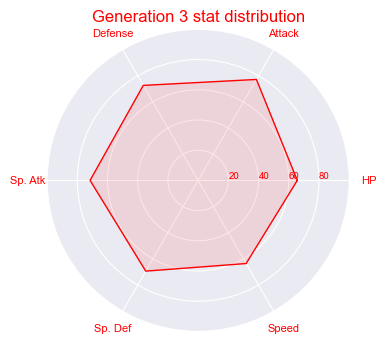

In [101]:
color = "red"
generation = 3
draw_spider_plot_stats(stats_list_complete[2],color,generation)

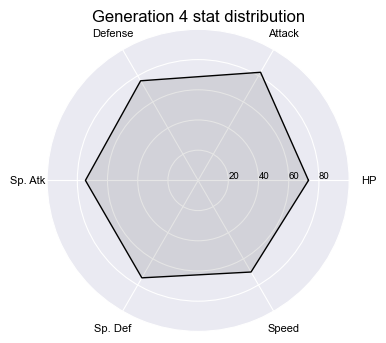

In [102]:
color = "black"
generation = 4
draw_spider_plot_stats(stats_list_complete[3],color,generation)

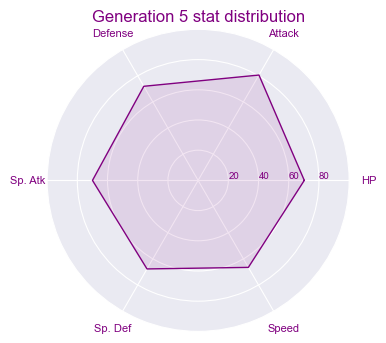

In [103]:
color = "purple"
generation = 5
draw_spider_plot_stats(stats_list_complete[4],color,generation)

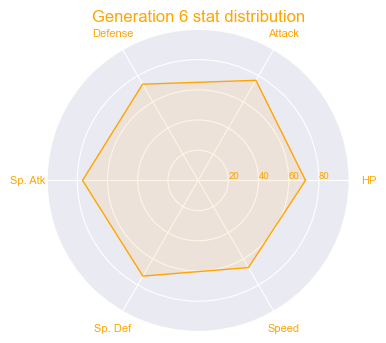

In [104]:
color = "orange"
generation = 6
draw_spider_plot_stats(stats_list_complete[5],color,generation)

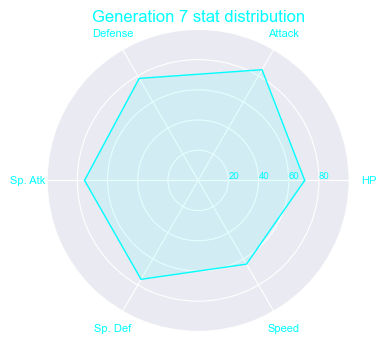

In [105]:
color = "cyan"
generation = 7
draw_spider_plot_stats(stats_list_complete[6],color,generation)

### PART B: Decision tree and random forest

The next step was to apply a simple decision tree to determine if a Pokémon was legendary, or not.
We applied this to both datasets (the latter one being more complete as it had information on a Pokémon's weight, size, etc., which the first dataset did not have).
We also made use of the random forest package in order to get a feature's significance in building a decision tree.

The tree generated using the second dataset is not as deep, presumably because notable features are present within the second dataset that help guide the decision tree more explicitely, such as base happiness or egg steps.

In [29]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.model_selection import train_test_split

In [133]:
# Read in input file
data = pd.read_csv('data/Pokemon.csv')
# Read in alternative, more complete input file ==> includes an extra generation
# Dataset has been modified to have matching col names (but not order) as first dataset
# Also removed the type effectiveness columns, but kept height, weight, exp, happiness, percentage male
data2 = pd.read_csv('data/pokemon_dataset_2.csv')

# Split dataset 1
def numeric_data_split_1(dataset):
    legendary_class = dataset["Legendary"]
    dataset = dataset.drop(["#", "Generation","Legendary"],axis=1)
    dataset = dataset.fillna(0)
    data_num = dataset._get_numeric_data()
    
    return train_test_split(data_num, legendary_class,test_size = 0.2)

# Split dataset 2
def numeric_data_split_2(dataset):
    legendary_class = dataset["Legendary"]
    dataset = dataset.drop(["percentage_male", "#", "Generation", "Legendary","height_m","weight_kg"],axis=1) # Drop three numeric metrics that aren't relevant + Class
    #dataset = dataset[["base_egg_steps","Total","base_happiness","experience_growth","Sp. Atk"]] # Keep top 5 metrics that are relevant
    dataset = dataset.fillna(0)
    data_num = dataset._get_numeric_data()
    
    return train_test_split(data_num, legendary_class,test_size = 0.2)

X_train, X_test, Y_train, Y_test = numeric_data_split_1(data)
X_train_2, X_test_2, Y_train_2, Y_test_2 = numeric_data_split_2(data2)

In [151]:
# Using the tree library from sklearn in order to build a tree to decide if a Pokémon is legendary
# To do so, only consider numerical integer features (np.int64)
# DATASET 1
md = 10
clf = tree.DecisionTreeClassifier(max_depth = md)
feature_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
clf = clf.fit(X_train[feature_int], Y_train)
class_pred_DT = clf.predict(X_train[feature_int])

# Use graphviz to export our decision tree into a visible PDF
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_int, 
                                class_names=['Not Legendary', 'Legendary'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('figures/Legendary status')

'figures/Legendary status.pdf'

ROC AUC score for max depth = 10: 0.8938802083333334


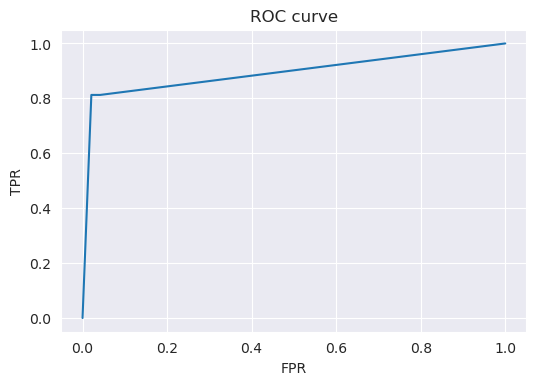

In [158]:
from sklearn.metrics import roc_curve, roc_auc_score

predictions = clf.predict_proba(X_test)
print("ROC AUC score for max depth = "+str(md)+": " +str(roc_auc_score(Y_test, predictions[:,1])))

fpr, tpr, _ = roc_curve(Y_test, predictions[:,1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

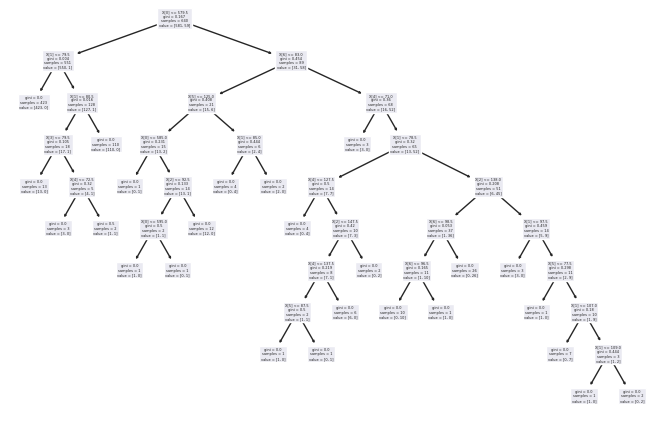

In [149]:
# A quick view of the generated tree (for a more detailed view, refer to the PDF file)
tree.plot_tree(clf)
plt.show

In [126]:
# Example: What is the decision path for a (hypothetical) Pokémon of stats: 700, 100, 180, 120, 30, 70 and 200?
print(clf.decision_path([[700, 100, 180, 120, 30, 70, 200]]))

  (0, 0)	1
  (0, 10)	1
  (0, 16)	1
  (0, 17)	1


[0.43833869 0.10879677 0.05580223 0.06717744 0.14737599 0.07266164
 0.10984725]


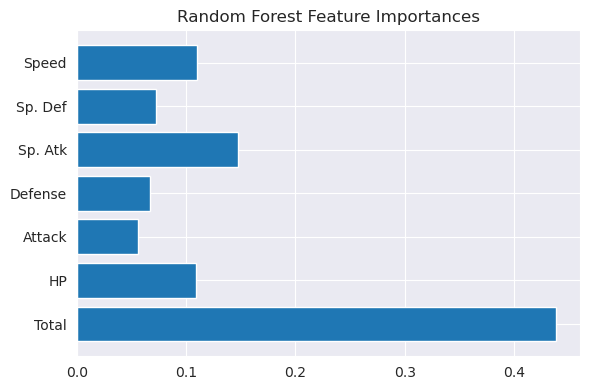

In [127]:
# Using the random forest classifier to fit a number of decision trees on various sub samples of dataset
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(data[feature_int], data['Legendary'])
class_pred_RF = clf.predict(data[feature_int])

# Output the importance of each feature
importance = clf.feature_importances_
print(importance)

y_ticks = np.arange(0, len(feature_int))
fig, ax = plt.subplots()
ax.barh(y_ticks, importance)
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_int)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

In [159]:
# Using the tree library from sklearn in order to build a tree to decide if a Pokémon is legendary
# To do so, only consider numerical features (np.int64)
# DATASET 2
md2 = 5
clf2 = tree.DecisionTreeClassifier(max_depth = md2)
feature_int = [feature for feature in data2.columns if type(data2[feature][0])==np.int64 and feature not in ['Generation', '#']]

print(feature_int)

clf2 = clf2.fit(X_train_2[feature_int], Y_train_2)
class_pred_DT = clf2.predict(X_train_2[feature_int])

# Use graphviz to export our decision tree into a visible PDF
dot_data = tree.export_graphviz(clf2, out_file=None, feature_names=feature_int, 
                                 class_names=['Not Legendary', 'Legendary'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('figures/Legendary status, dataset 2')

['Attack', 'base_egg_steps', 'base_happiness', 'Total', 'capture_rate', 'Defense', 'experience_growth', 'HP', 'Sp. Atk', 'Sp. Def', 'Speed']


'figures/Legendary status, dataset 2.pdf'

ROC AUC score for max depth = 5: 1.0


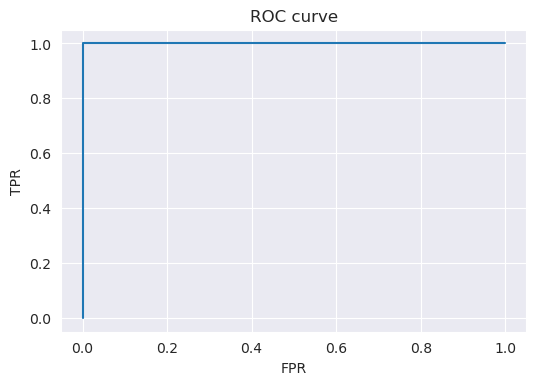

In [160]:
from sklearn.metrics import roc_curve, roc_auc_score

predictions = clf2.predict_proba(X_test_2)
print("ROC AUC score for max depth = "+str(md2)+": " +str(roc_auc_score(Y_test_2, predictions[:,1])))

fpr, tpr, _ = roc_curve(Y_test_2, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

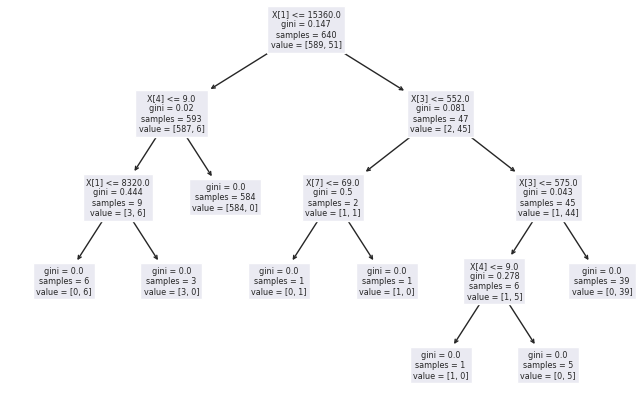

In [120]:
# A quick view of the generated tree (for a more detailed view, refer to the PDF file)
tree.plot_tree(clf2)
plt.show

[0.0085161  0.33355999 0.10251161 0.15833688 0.25071332 0.01275012
 0.05216903 0.02099252 0.02637463 0.01756549 0.01651032]


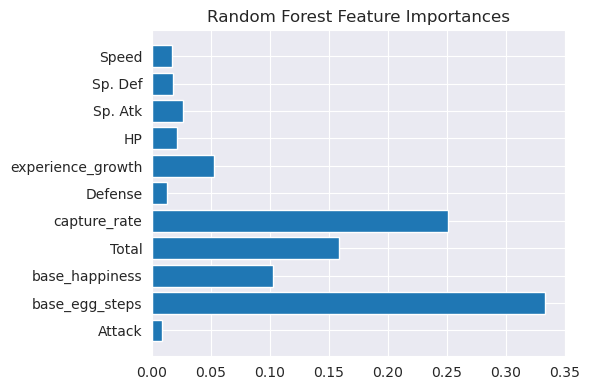

In [121]:
# Using the random forest classifier to fit a number of decision trees on various sub samples of dataset
clf2 = RandomForestClassifier(max_depth=5, random_state=0)
clf2.fit(data2[feature_int], data2['Legendary'])
class_pred_RF = clf2.predict(data2[feature_int])

# Output the importance of each feature
importance = clf2.feature_importances_
print(importance)

y_ticks = np.arange(0, len(feature_int))
fig, ax = plt.subplots()
ax.barh(y_ticks, importance)
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_int)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

### PART C: Logistic regression
Logistic regression was the next tool utilised in order to predict whether a Pokémon was legendary or not. This also works since the logistic function fits a log function over a binary prediction.

In [196]:
from sklearn.linear_model import LogisticRegression
from src.logistic_regression import *

In [203]:
# DATASET 1 - more forms, mega evolutions of same Pokémon, 6 generations
data = pd.read_csv('data/Pokemon.csv')

feature_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
print(feature_int, '\n')
#feature_int = ['Total', 'Attack']
updateTypeColumn(data, 'Legendary', True)
data['Legendary'] = data['Legendary'].apply(int) # Converts column to int

accuracies, errors = K_fold_logistic_regression(data, feature_int, 'Legendary', 5)
print('\naccuracies :', accuracies)
print('errors :', errors)

['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'] 

k folding n° 1
SIZE :
train -> 640 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 60 / validation -> 15
k folding n° 2
SIZE :
train -> 640 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 57 / validation -> 18
k folding n° 3
SIZE :
train -> 640 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 64 / validation -> 11
k folding n° 4
SIZE :
train -> 640 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 59 / validation -> 16
k folding n° 5
SIZE :
train -> 640 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 60 / validation -> 15

accuracies : [0.6375, 0.8875, 0.93125, 0.9, 0.90625]
errors : [0.36250000000000004, 0.11250000000000004, 0.06874999999999998, 0.09999999999999998, 0.09375]


In [206]:
# DATASET 2 - less forms, no repeats same Pokémon, 7 generations
data2 = pd.read_csv('data/pokemon_dataset_2.csv')

feature_int = [feature for feature in data2.columns if type(data2[feature][0])==np.int64 and feature not in ['Generation', '#']]
print(feature_int, '\n')
#feature_int = ['Total', 'Attack']
updateTypeColumn(data2, 'Legendary', True)
data2['Legendary'] = data2['Legendary'].apply(int) # Converts column to int

accuracies, errors = K_fold_logistic_regression(data2, feature_int, 'Legendary', 5)
print('\naccuracies :', accuracies)
print('errors :', errors)

['Attack', 'base_egg_steps', 'base_happiness', 'Total', 'Defense', 'experience_growth', 'HP', 'Sp. Atk', 'Sp. Def', 'Speed'] 

k folding n° 1
SIZE :
train -> 641 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 57 / validation -> 13
k folding n° 2
SIZE :
train -> 641 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 53 / validation -> 17
k folding n° 3
SIZE :
train -> 641 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 57 / validation -> 13
k folding n° 4
SIZE :
train -> 641 / validation -> 160
NUMBER OF LEGENDARIES :
train -> 55 / validation -> 15
k folding n° 5
SIZE :
train -> 640 / validation -> 161
NUMBER OF LEGENDARIES :
train -> 58 / validation -> 12

accuracies : [0.91875, 0.99375, 0.99375, 0.9875, 0.9813664596273292]
errors : [0.08125000000000004, 0.006249999999999978, 0.006249999999999978, 0.012499999999999956, 0.018633540372670843]


### PART D: Clustering and dimensionality reduction

Here, we cluster pairwise features against each other in other to see whether the "legendary" class can be explicitely seen.
By using the previously computed highest significance features by using the random forest classifier, we can get relevant cluster formation with features such as base_egg_steps vs total, and sp atk vs total.

However, it becomes evident that most clustering methods fail to properly segregate unless they are very explicitely separated, as shown in the base_egg_steps vs total plots.

The next step was to use the most informative features together and PCA them to 2 dimensions and try clustering again.
There are roughly a dozen numerical features, and 4-5 are significant. The rest are not as worthy of consideration.

In [4]:
# 2-means clustering function for the Pokémon dataset
# First shows the expected classes (Legendary vs non legendary)
# Then, tries three different clustering methods on dataset.

# Clustering imports
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
k = 2  # 2 clusters: whether a Pokémon is legendary or not

# Styling
import seaborn as sns
sns.set_style('darkgrid')
palette = sns.color_palette('deep')
colors_sns = palette[0:k]               # Palette changes if k varies


def kmeans_pokemon(dataset,feature1,feature2,class_to_predict):

    X = dataset[[feature1, feature2]]  # Features 1 and 2 as x and y axis
    Y = dataset[class_to_predict]      # Class to predict: legendary or not (binary)

    ### --- Features against known class --- ###
    # Done for every generation
    plot = sns.lmplot(x=feature1, y=feature2, hue=class_to_predict, col = "Generation", palette = palette, data = dataset, markers=["o", "x"], col_wrap=3, height=2.5, fit_reg=False,)
    # All generations together
    plot2 = sns.lmplot(x=feature1, y=feature2, hue=class_to_predict, palette = palette, data = dataset, markers=["o", "x"], fit_reg=False,)
    plt.title("All generations - True classification")

    ### --- K-mean --- ###
    plt.figure()

    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)    # Cluster, maximum of 100 iterations 
    km.fit(X)                                                              # Fit on features 1 and 2
    labels = km.fit_predict(X)                                             # Get labels
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color=[colors_sns[l_] for l_ in labels], label=labels)

    plt.title("K-means clustering on "+feature1+" and "+feature2)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    ### --- Hierarchichal --- ###
    plt.figure()

    hierarchichal = AgglomerativeClustering(linkage="average", n_clusters=k)
    hierarchichal.fit(X)
    labels = hierarchichal.fit_predict(X)

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color=[colors_sns[l_] for l_ in labels], label=labels)
    plt.title("Hierarchical clustering on "+feature1+" and "+feature2)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    ### --- Spectral clustering --- ### 
    plt.figure()

    spectral = SpectralClustering(n_clusters=k, eigen_solver='arpack', affinity="nearest_neighbors")
    spectral.fit(X)
    labels = spectral.fit_predict(X)    

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color=[colors_sns[l_] for l_ in labels], label=labels)
    plt.title("Spectral Clustering on "+feature1+" and "+feature2)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    return km,hierarchichal,spectral


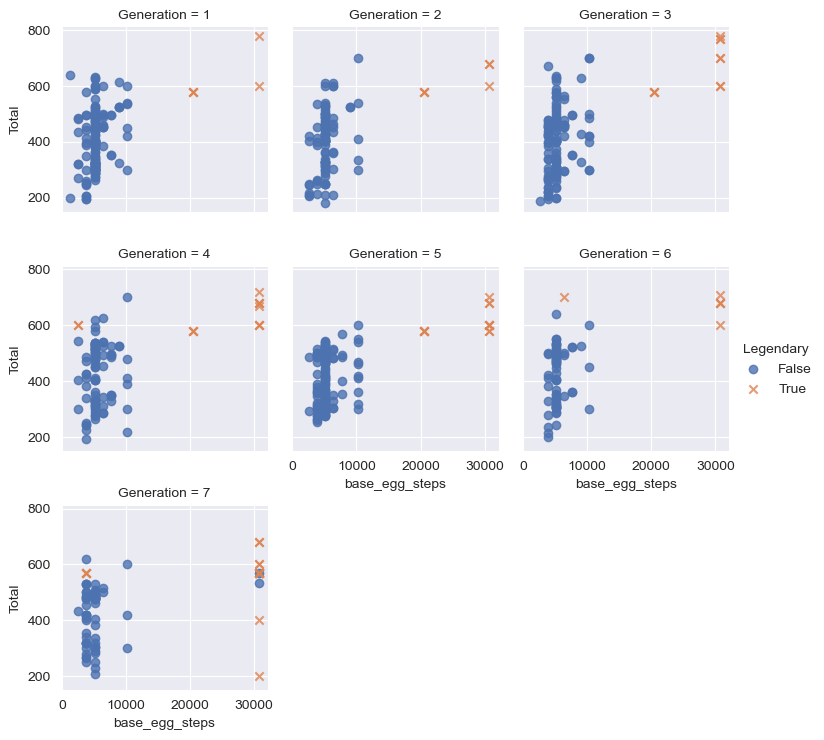

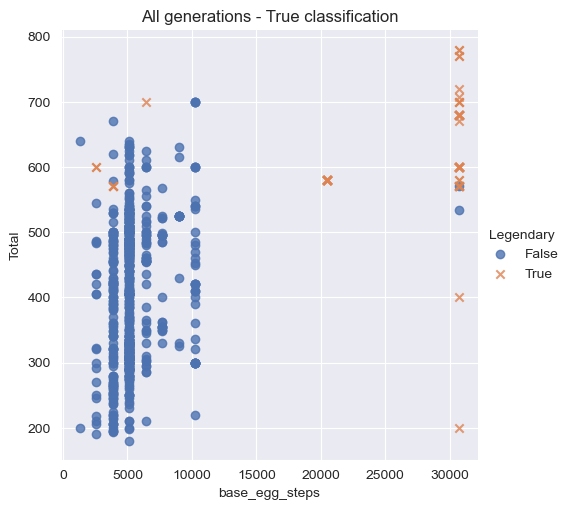

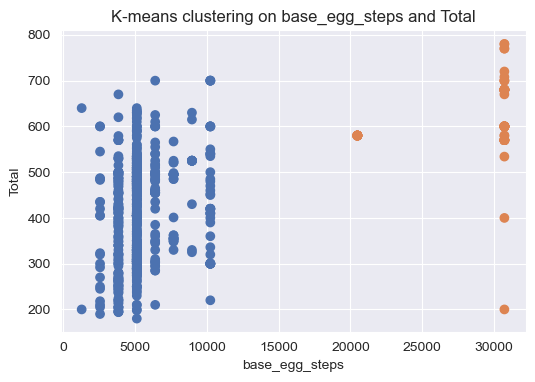

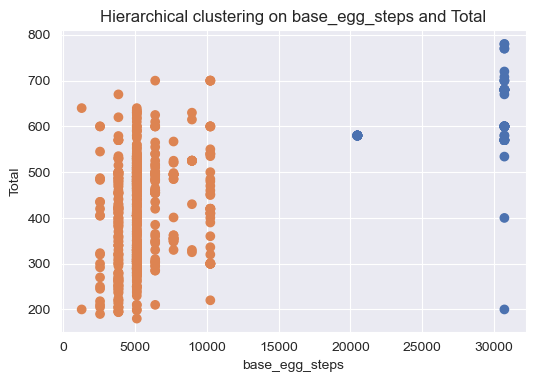

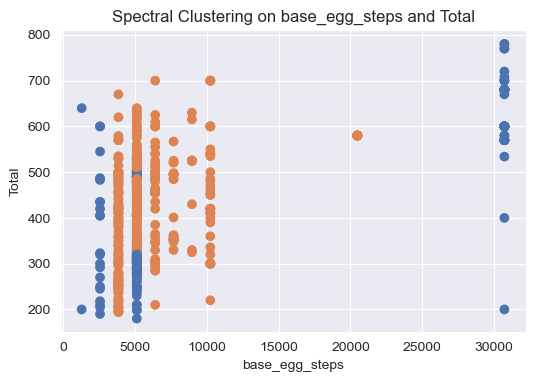

(KMeans(max_iter=100, n_clusters=2, n_init=1),
 AgglomerativeClustering(linkage='average'),
 SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                    n_clusters=2))

In [5]:
data2 = pd.read_csv('data/pokemon_dataset_2.csv')
kmeans_pokemon(data2,"base_egg_steps","Total","Legendary")

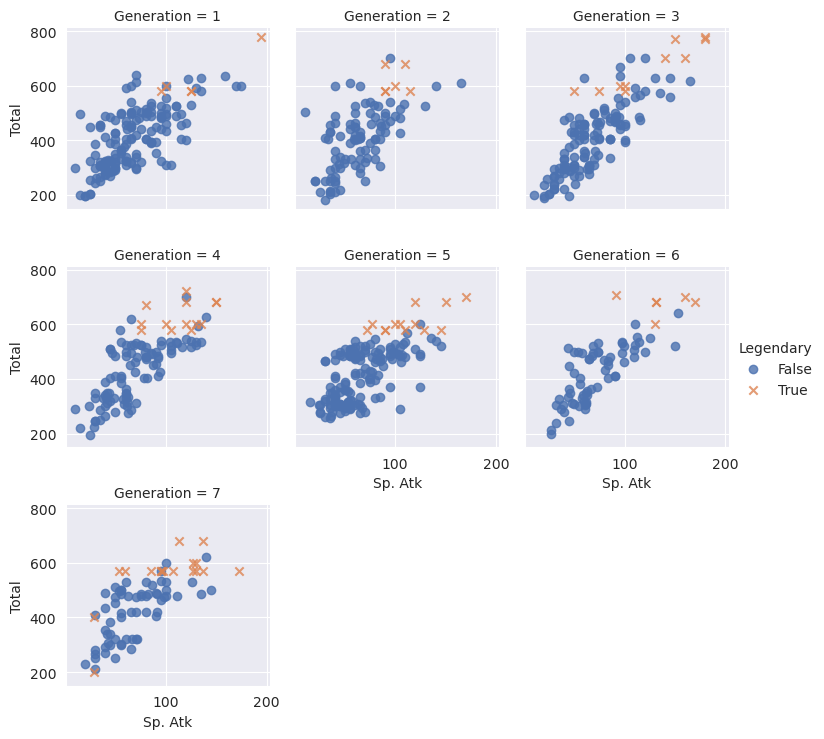

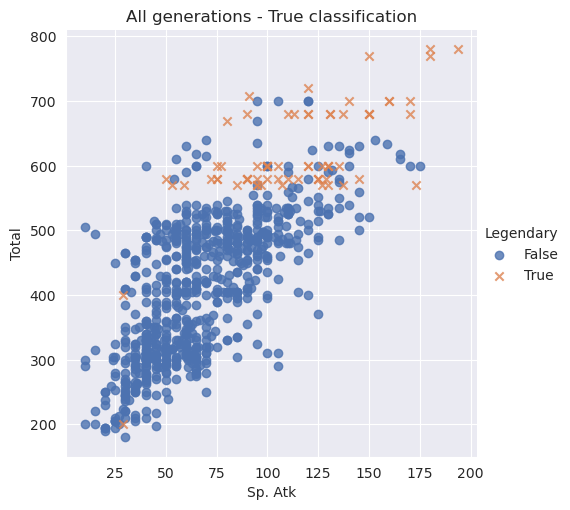

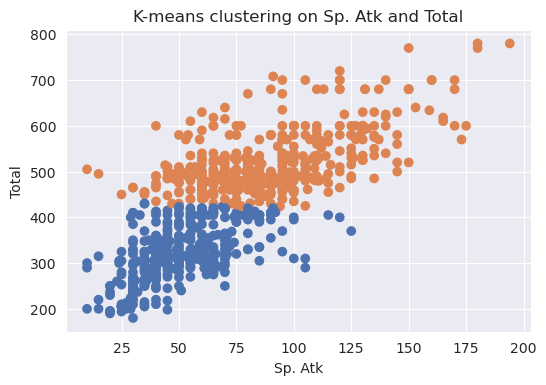

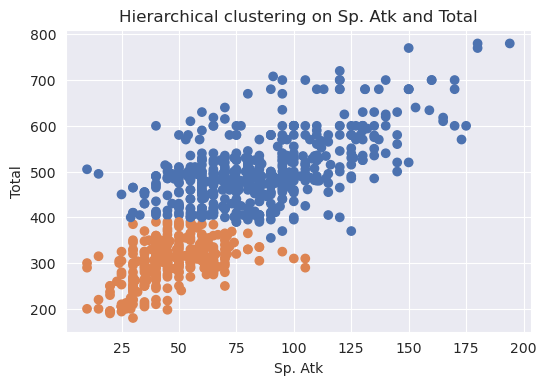

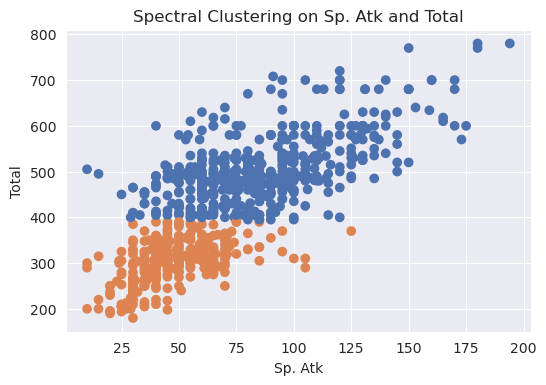

(KMeans(max_iter=100, n_clusters=2, n_init=1),
 AgglomerativeClustering(linkage='average'),
 SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                    n_clusters=2))

In [8]:
data2 = pd.read_csv('data/pokemon_dataset_2.csv')
kmeans_pokemon(data2,"Sp. Atk","Total","Legendary")

In [2]:
# Split into testing and training data on numerics
from sklearn.model_selection import train_test_split

def numeric_data_split(dataset):
    legendary_class = dataset["Legendary"]
    dataset = dataset.drop(["percentage_male", "#", "Generation", "Legendary"],axis=1) # Drop three numeric metrics that aren't relevant + Class
    #dataset = dataset[["base_egg_steps","Total","base_happiness","experience_growth","Sp. Atk"]] # Keep top 5 metrics that are relevant
    dataset = dataset.fillna(0)
    
    data_num = dataset._get_numeric_data()

    return train_test_split(data_num, legendary_class,test_size = 0.2)

data2 = pd.read_csv('data/pokemon_dataset_2.csv')
X_train, X_test, Y_train, Y_test = numeric_data_split(data2)
X_train

,Attack,base_egg_steps,base_happiness,Total,capture_rate,Defense,experience_growth,height_m,HP,Sp. Atk,Sp. Def,Speed,weight_kg
352,75,6400,35,295,225,35,800000,0.6,44,63,33,45,2.3
765,120,5120,70,490,45,90,1250000,2.0,100,40,60,80,82.8
362,40,5120,70,290,255,50,1059860,0.8,70,55,50,25,39.5
51,35,5120,70,290,255,35,1000000,0.0,40,50,40,90,0.0
348,15,5120,70,200,255,20,600000,0.6,20,10,55,80,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,60,3840,70,360,255,60,800000,1.1,60,60,60,60,5.0
640,100,30720,90,580,3,80,1250000,1.5,79,110,90,121,63.0
676,48,5120,70,355,190,54,1000000,0.3,62,63,60,68,3.5
502,100,5120,70,528,45,85,1059860,1.5,95,108,70,70,94.6


In [3]:
### --- PCA STEP --- ### 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# from sklearn import fit_predict

clustering_methods = []

x = StandardScaler().fit_transform(X_train) # Standardize data so it doesn't put too much weight on extremely high values
pca_2 = PCA(n_components=2)                 # Keep 2 components for 2 visualisation
pca_train_2 = pca_2.fit_transform(x)
print('Cumulative explained variation for 2 principal components: {}'.format(np.sum(pca_2.explained_variance_ratio_)))


### --- K-MEAN STEP --- ### 
plt.figure()
km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)    # Cluster, maximum of 100 iterations 
km.fit(pca_train_2)                                                    # Fit on features 1 and 2
clustering_methods.append(km)                                          # Append in clustering methods list
labels = km.fit_predict(pca_train_2)                                   # Get labels
plt.scatter(pca_train_2[:, 0], pca_train_2[:, 1], color=[colors_sns[l_] for l_ in labels], label=labels)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("K-means clustering after PCA")
plt.show()

### --- HIERARCHICAL STEP --- ###
plt.figure()
hierarchichal = AgglomerativeClustering(linkage="average", n_clusters=k)
hierarchichal.fit(pca_train_2)
clustering_methods.append(hierarchichal)                                         
labels = hierarchichal.fit_predict(pca_train_2)
plt.scatter(pca_train_2[:, 0], pca_train_2[:, 1], color=[colors_sns[l_] for l_ in labels], label=labels)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Hierarchichal clustering after PCA")
plt.show()

### --- SPECTRAL CLUSTERING STEP --- ### 
plt.figure()
spectral = SpectralClustering(n_clusters=k, eigen_solver='arpack', affinity="nearest_neighbors")
spectral.fit(pca_train_2)
clustering_methods.append(spectral)                                          # Append in clustering methods list
labels = spectral.fit_predict(pca_train_2)    
plt.scatter(pca_train_2[:, 0], pca_train_2[:, 1], color=[colors_sns[l_] for l_ in labels], label=labels)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Spectral clustering after PCA")
plt.show()

### --- VERIFY METRICS --- ###

# Compare to true labels
plt.figure()
plt.scatter(pca_train_2[:, 0], pca_train_2[:, 1], color=[colors_sns[l_] for l_ in Y_train], label=Y_train)
plt.title("True label comparison")
plt.show()

# In order: K means, hierachical, spectral
print("Metrics on training data: ")
for method in clustering_methods:
    print("Homogeneity score: "+str(metrics.homogeneity_score(Y_train, method.labels_)))
    print("Completeness score: "+str(metrics.completeness_score(Y_train, method.labels_)))
    print("V Measure score: "+str(metrics.v_measure_score(Y_train, method.labels_)))
    print("Adjusted rand score score: "+str(metrics.adjusted_rand_score(Y_train, method.labels_)))
    print("Silhouette score: "+str(metrics.silhouette_score(X_train, method.labels_)))
    print("\n")

Cumulative explained variation for 2 principal components: 0.5410676088575156


NameError: name 'KMeans' is not defined

<Figure size 600x400 with 0 Axes>

In [4]:
def normalize_features(data, features):
    for feature in features:
        data[feature] = data[feature].div(max(data[feature]), axis=0)
    return data

In [5]:
from src.logistic_regression import *
#data = pd.read_csv('data/Pokemon.csv')
data = pd.read_csv('data/pokemon_dataset_2.csv')
all_features = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
best_features = ['Total', 'base_egg_steps', 'base_happiness', 'experience_growth']
print('all the features that we take care :', all_features)
print('Most corraleted features :', best_features, '\n')
normalize_features(data, all_features)
updateTypeColumn(data, 'Legendary', True)
data['Legendary'] = data['Legendary'].apply(int) # Converts column to int
data = data[all_features+['Legendary']]


all the features that we take care : ['Attack', 'base_egg_steps', 'base_happiness', 'Total', 'capture_rate', 'Defense', 'experience_growth', 'HP', 'Sp. Atk', 'Sp. Def', 'Speed']
Most corraleted features : ['Total', 'base_egg_steps', 'base_happiness', 'experience_growth'] 



### PART E: LOGISTIC REGRESSION
#### All features

In [8]:
accuracy, precision, theta = K_fold_logistic_regression(data, all_features, 'Legendary', 5, iterations=4000, N=10)
print('\nAverage accuracy :', accuracy)
print('Average precision :', precision)
print('Average Theta :', theta)

10 / 10

Average accuracy : 0.9017158385093167
Average precision : 0.08149403581657381
Average Theta : [-0.20559239  0.29649489 -0.36983776 -0.4324528  -0.37111636 -0.06526091
 -0.62620475  0.02017283 -0.12098521 -0.02530292 -0.04145372]


#### Best features

In [7]:
accuracy, precision, theta = K_fold_logistic_regression(data, best_features, 'Legendary', 5, iterations=4000, N=10)
print('\nAverage accuracy :', accuracy)
print('Average precision :', precision)
print('Average Theta :', theta)

10 / 10

Average accuracy : 0.9063540372670807
Average precision : 0.2316011904761905
Average Theta : [-0.42456532  0.23226571 -0.30397868 -0.55889356]


### PART F: SPECIAL METHOD

In [7]:
from src.special_method import *
spec_met_all = K_fold_special_method(data, all_features, 'Legendary', 5, 10, 1.75)
spec_met_best = K_fold_special_method(data, best_features, 'Legendary', 5, 10, 0.95)
print('Features', 'Accuracy', 'Precision', 'Recall', 'F-score', sep='            ')
print('All features', spec_met_all)
print('Best features', spec_met_best)

10 / 10
Features            Accuracy            Precision            Recall            F-score
All features (0.979651397515528, 0.8944436479413259, 0.8668430120790801, 0.8754709969454997)
Best features (0.9850201863354038, 0.9644205896442739, 0.8477291794033279, 0.8991719500466802)
